In [1]:
#pip installs
!pip install --quiet scanpy anndata scvi-tools matplotlib seaborn numpy pandas
!pip install --quiet scib-metrics

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 641.1/641.1 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 53.9 MB/s eta 0:00:00
 

In [2]:
#imports
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scib_metrics
from scib_metrics.nearest_neighbors._dataclass import NeighborsResults



In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#full file paths
MG_PATH = "/content/drive/MyDrive/data_science_final_project/data_processed/dataset2_full.h5ad"
HEALTHY_PATH = "/content/drive/MyDrive/data_science_final_project/raw_data/healthy_thymus_full.h5ad"

In [5]:
PRINT_CHECKS = False

In [6]:
# extract directories - confirm directories exist
MG_DIR = os.path.dirname(MG_PATH)
HEALTHY_DIR = os.path.dirname(HEALTHY_PATH)

if (PRINT_CHECKS == True):
  print("MG directory exists?:", os.path.exists(MG_DIR), "-------------", MG_DIR)
  print("Healthy directory exists?:", os.path.exists(HEALTHY_DIR), "-------------", HEALTHY_DIR)

  print("-----------------------------------------------------------------")

  print("MG dataset2_full.h5ad exists?:", os.path.exists(MG_PATH))
  print("Healthy healthy_thymus_full.h5ad exists?:", os.path.exists(HEALTHY_PATH))


In [7]:
#load both datasets
mg = sc.read_h5ad(MG_PATH)
healthy = sc.read_h5ad(HEALTHY_PATH)

In [8]:
if (PRINT_CHECKS == True):
  print(mg)
  print("Number of cells:", mg.n_obs)
  print("Number of genes:", mg.n_vars)

  print("\nMG .obs columns:")
  print(mg.obs.columns.tolist())


In [9]:
if (PRINT_CHECKS == True):
  print("MG ontology labels:")
  print(mg.obs["cell_type__ontology_label"].value_counts())


In [10]:
if (PRINT_CHECKS == True):
#inspect MG dataset
  print("\n\n===== MG THYMUS DATASET =====")
  print(mg)

  print("\nMG .obs columns:")
  print(mg.obs.columns.tolist())

  print("\nMG .var columns:")
  print(mg.var.columns.tolist())

  print("\nMG cell_type preview:")
  if "cell_type" in mg.obs:
      print(mg.obs["cell_type"].value_counts().head(30))
  else:
      print("No 'cell_type' column found in MG. We will inspect alternatives later.")

 #inspect healthy dataset
  print("\n\n===== HEALTHY THYMUS DATASET =====")
  print(healthy)

  print("\nHealthy .obs columns:")
  print(healthy.obs.columns.tolist())

  print("\nHealthy .var columns:")
  print(healthy.var.columns.tolist())

  print("\nHealthy cell_type preview:")
  if "cell_type" in healthy.obs:
      print(healthy.obs["cell_type"].value_counts().head(30))
  else:
      print("No 'cell_type' column found in Healthy. We will detect the correct label column later.")

  print("\n\n===== DONE LOADING AND INSPECTION =====")

In [11]:
#QC on MG + Healthy Thymus

import numpy as np
import scanpy as sc

def qc_filter(adata, name):
    ad = adata.copy()

    if (PRINT_CHECKS == True):
      print(f"\n========== QC for {name} ==========")
      print(f"Initial: {ad.n_obs} cells, {ad.n_vars} genes")

    #mark mitochondrial_genes
    if "mt" not in ad.var.columns:
        ad.var["mt"] = ad.var_names.str.upper().str.startswith("MT-")

    #calculate QC metrics
    sc.pp.calculate_qc_metrics(ad, qc_vars=["mt"], inplace=True)

    if (PRINT_CHECKS == True):
      #print QC metric summary
      print("\nQC metric summary (before filtering):")
      print("n_genes_by_counts:")
      print(ad.obs["n_genes_by_counts"].describe())
      print("\ntotal_counts:")
      print(ad.obs["total_counts"].describe())
      print("\npct_counts_mt:")
      print(ad.obs["pct_counts_mt"].describe())

    #QC rules
    ad = ad[ad.obs["pct_counts_mt"] < 15, :]
    ad = ad[ad.obs["n_genes_by_counts"] > 200, :]
    ad = ad[ad.obs["n_genes_by_counts"] < 6000, :]
    if "total_counts" in ad.obs.columns:
        ad = ad[ad.obs["total_counts"] < 3e5, :]

    #filter genes to ones expressed in at least 10 cells
    sc.pp.filter_genes(ad, min_cells=10)

    if (PRINT_CHECKS == True):
      #QC metric summary post filtering
      print(f"\nAfter filtering: {ad.n_obs} cells, {ad.n_vars} genes")
      print("\nn_genes_by_counts after:")
      print(ad.obs["n_genes_by_counts"].describe())
      print("\npct_counts_mt after:")
      print(ad.obs["pct_counts_mt"].describe())

    return ad


In [12]:
#QC each dataset
mg_qc = qc_filter(mg, "MG Thymus")
healthy_qc = qc_filter(healthy, "Healthy Thymus")

#metadata labels - add to dataset
mg_qc.obs["condition"] = "MG"
healthy_qc.obs["condition"] = "Healthy"

#sanity check - should return the same stuff as "condition" since dataset separated by condition in this implementation
mg_qc.obs["dataset"] = "MG_thymus"
healthy_qc.obs["dataset"] = "Healthy_thymus"

if (PRINT_CHECKS == True):
  print("\n===== QC COMPLETED =====")
  print("MG QC:", mg_qc)
  print("Healthy QC:", healthy_qc)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [13]:
if (PRINT_CHECKS == True):

  print("===== MG_QC ontology-based cell types =====")

  if "cell_type__ontology_label" in mg_qc.obs:
      print(mg_qc.obs["cell_type__ontology_label"].value_counts())
  else:
      print("MG_QC: No ontology label column found.")


In [14]:
#Downsample healthy thymus to match mg thymus size

import numpy as np

# MG cell count after QC
TARGET_HEALTHY = mg_qc.n_obs
if (PRINT_CHECKS == True):
  print("Target MG thymus cell count:", TARGET_HEALTHY)

# Downsample Healthy thymus to match MG cell count
np.random.seed(0)  # ensures reproducibility

if healthy_qc.n_obs > TARGET_HEALTHY:
    keep_idx = np.random.choice(
        healthy_qc.n_obs,
        size=TARGET_HEALTHY,
        replace=False
    )
    healthy_down = healthy_qc[keep_idx, :].copy()
    print(f"\nHealthy thymus downsampled: {healthy_qc.n_obs} -------- {healthy_down.n_obs} cells")
else:
    healthy_down = healthy_qc.copy()
    print("\nHealthy thymus already smaller than target — no downsampling.")

if (PRINT_CHECKS == True):
  print("\n===== FINAL CELL COUNTS =====")
  print("MG thymus:", mg_qc.n_obs)
  print("Healthy thymus (downsampled):", healthy_down.n_obs)



Healthy thymus downsampled: 482093 -------- 64024 cells


In [15]:
#-----------------------------------------------------for QCed datasets, can go from here ----------------------------------------

In [16]:
#save intermedate datasets

SAVE_DIR = "/content/drive/MyDrive/data_science_final_project/data_processed"
os.makedirs(SAVE_DIR, exist_ok=True)

MG_QC_PATH = f"{SAVE_DIR}/mg_thymus_QC.h5ad"
HEALTHY_QC_PATH = f"{SAVE_DIR}/healthy_thymus_QC.h5ad"
HEALTHY_DOWN_PATH = f"{SAVE_DIR}/healthy_thymus_downsampled.h5ad"

if (PRINT_CHECKS == True):
  print("\n===== SAVING INTERMEDIATE FILES =====")

mg_qc.write(MG_QC_PATH)

if (PRINT_CHECKS == True):
  print(f"Saved MG QC dataset ----- {MG_QC_PATH}")

healthy_qc.write(HEALTHY_QC_PATH)

if (PRINT_CHECKS == True):
  print(f"Saved Healthy QC dataset ----- {HEALTHY_QC_PATH}")

healthy_down.write(HEALTHY_DOWN_PATH)

if (PRINT_CHECKS == True):
  print(f"Saved Healthy Downsampled dataset ------ {HEALTHY_DOWN_PATH}")

if (PRINT_CHECKS == True):
  print("\nAll intermediate datasets saved successfully.")


In [17]:
#---------------------------------------------- can reload from here for QC ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:

# RELOAD INTERMEDIATE DATASETS


import scanpy as sc

SAVE_DIR = "/content/drive/MyDrive/data_science_final_project/data_processed"

MG_QC_PATH = f"{SAVE_DIR}/mg_thymus_QC.h5ad"
HEALTHY_QC_PATH = f"{SAVE_DIR}/healthy_thymus_QC.h5ad"
HEALTHY_DOWN_PATH = f"{SAVE_DIR}/healthy_thymus_downsampled.h5ad"

if (PRINT_CHECKS == True):
  print("===== LOADING INTERMEDIATE FILES =====")

mg_qc = sc.read_h5ad(MG_QC_PATH)

if (PRINT_CHECKS == True):
  print(f"Loaded MG QC dataset ----- {mg_qc.shape}")

healthy_qc = sc.read_h5ad(HEALTHY_QC_PATH)

if (PRINT_CHECKS == True):
  print(f"Loaded Healthy QC dataset ----- {healthy_qc.shape}")

healthy_down = sc.read_h5ad(HEALTHY_DOWN_PATH)

if (PRINT_CHECKS == True):
  print(f"Loaded Healthy Downsampled dataset ----- {healthy_down.shape}")

  print("\nAll datasets loaded successfully.")


In [19]:
if (PRINT_CHECKS == True):

  mg_qc.var.head()
  print(mg_qc.var.columns)
  print(mg_qc.var_names[:20])


In [20]:
if (PRINT_CHECKS == True):

  print("===== MG_QC: cell_type__ontology_label counts =====")

  if "cell_type__ontology_label" in mg_qc.obs:
      print(mg_qc.obs["cell_type__ontology_label"].value_counts())
  else:
      print("MG_QC: No ontology_label column present.")


In [21]:
if (PRINT_CHECKS == True):
  print("===== Healthy_QC: cell_type counts =====")
  if "cell_type" in healthy_qc.obs:
      print(healthy_qc.obs["cell_type"].value_counts().head(50))
  else:
      print("Healthy_QC: No 'cell_type' field found.")


In [22]:
if (PRINT_CHECKS == True):
  print("===== MG .var columns =====")
  print(mg_qc.var.columns)


In [23]:
if (PRINT_CHECKS == True):
  print("\n===== MG example rows =====")
  print(mg_qc.var.head(10))


In [24]:
print("===== Healthy .var columns =====")
print(healthy_qc.var.columns)


===== Healthy .var columns =====
Index(['feature_is_filtered', 'feature_name', 'feature_reference',
       'feature_biotype', 'feature_length', 'feature_type', 'mt',
       'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells'],
      dtype='object')


In [25]:
if (PRINT_CHECKS == True):
  healthy_qc.var.head()
  print(healthy_qc.var.columns)
  print(healthy_qc.var_names[:20])

In [26]:
healthy_qc.var_names = healthy_qc.var["feature_name"].astype(str)
healthy_qc.var_names.name = None

healthy_down.var_names = healthy_down.var["feature_name"].astype(str)
healthy_down.var_names.name = None


In [27]:
common_genes = mg_qc.var_names.intersection(healthy_down.var_names)
print("Number of shared genes:", len(common_genes))
print("Example shared genes:", list(common_genes)[:20])


Number of shared genes: 17681
Example shared genes: ['LINC01409', 'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'C1orf159', 'LINC01342', 'TTLL10-AS1', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4']


In [28]:
if (PRINT_CHECKS == True):
  healthy_down.var_names.is_unique


In [29]:
if (PRINT_CHECKS == True):

  print("===== MG_QC: cell_type__ontology_label counts =====")

  if "cell_type__ontology_label" in mg_qc.obs:
      print(mg_qc.obs["cell_type__ontology_label"].value_counts())
  else:
      print("MG_QC: No ontology_label column present.")


  print("-------------------------------------------")



  print("===== Healthy_QC: cell_type counts =====")
  if "cell_type" in healthy_qc.obs:
      print(healthy_qc.obs["cell_type"].value_counts().head(50))
  else:
      print("Healthy_QC: No 'cell_type' field found.")



In [30]:
healthy_down.var_names_make_unique()
healthy_qc.var_names_make_unique()


In [31]:
if (PRINT_CHECKS == True):
  print("===== MG_QC: cell_type__ontology_label counts =====")

  if "cell_type__ontology_label" in mg_qc.obs:
      print(mg_qc.obs["cell_type__ontology_label"].value_counts())
  else:
      print("MG_QC: No ontology_label column present.")


  print("-------------------------------------------")



  print("===== Healthy_QC: cell_type counts =====")
  if "cell_type" in healthy_qc.obs:
      print(healthy_qc.obs["cell_type"].value_counts().head(50))
  else:
      print("Healthy_QC: No 'cell_type' field found.")



In [32]:
#subset mg + healthy thymus to shared genes

print("Subsetting both datasets to shared genes...")

mg_sub = mg_qc[:, common_genes].copy()
healthy_sub = healthy_down[:, common_genes].copy()

print("MG subset shape:", mg_sub.shape)
print("Healthy subset shape:", healthy_sub.shape)


Subsetting both datasets to shared genes...
MG subset shape: (64024, 17681)
Healthy subset shape: (64024, 17681)


In [33]:
MG_SUB_PATH = f"{SAVE_DIR}/mg_thymus_shared_genes.h5ad"
HEALTHY_SUB_PATH = f"{SAVE_DIR}/healthy_thymus_shared_genes.h5ad"

mg_sub.write(MG_SUB_PATH)
healthy_sub.write(HEALTHY_SUB_PATH)

print("Saved MG subset ----", MG_SUB_PATH)
print("Saved Healthy subset -----", HEALTHY_SUB_PATH)


Saved MG subset ---- /content/drive/MyDrive/data_science_final_project/data_processed/mg_thymus_shared_genes.h5ad
Saved Healthy subset ----- /content/drive/MyDrive/data_science_final_project/data_processed/healthy_thymus_shared_genes.h5ad


In [34]:
if (PRINT_CHECKS == True):
  print("===== MG_QC: cell_type__ontology_label counts =====")

  if "cell_type__ontology_label" in mg_sub.obs:
      print(mg_sub.obs["cell_type__ontology_label"].value_counts())
  else:
      print("MG_QC: No ontology_label column present.")


  print("-------------------------------------------")



  print("===== Healthy_QC: cell_type counts =====")
  if "cell_type" in healthy_sub.obs:
      print(healthy_sub.obs["cell_type"].value_counts().head(50))
  else:
      print("Healthy_QC: No 'cell_type' field found.")



In [35]:
#---------------------------------------------- can reload from here ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [36]:
#reload shared genes subset

import scanpy as sc
import os
import numpy as np

SAVE_DIR = "/content/drive/MyDrive/data_science_final_project/data_processed"

MG_SUB_PATH = f"{SAVE_DIR}/mg_thymus_shared_genes.h5ad"
HEALTHY_SUB_PATH = f"{SAVE_DIR}/healthy_thymus_shared_genes.h5ad"

print("===== LOADING SHARED-GENE SUBSETS =====")

mg_sub = sc.read_h5ad(MG_SUB_PATH)
print(f"Loaded MG subset ---- {mg_sub.shape}")

healthy_sub = sc.read_h5ad(HEALTHY_SUB_PATH)
print(f"Loaded Healthy subset ----- {healthy_sub.shape}")

print("\nShared-gene subsets loaded successfully.")

===== LOADING SHARED-GENE SUBSETS =====
Loaded MG subset ---- (64024, 17681)
Loaded Healthy subset ----- (64024, 17681)

Shared-gene subsets loaded successfully.


In [37]:
#concatinate 2 datasets

print("\nConcatenating MG and Healthy thymus datasets...")

combined = mg_sub.concatenate(
    healthy_sub,
    batch_key="dataset_label",
    batch_categories=["MG_thymus", "Healthy_thymus"],
    index_unique=None
)

print("\n===== COMBINED AnnData =====")
print(combined)
print("Cells:", combined.n_obs)
print("Genes:", combined.n_vars)


#add raw counts layer for scvi
if "counts" not in combined.layers:
    print("Adding raw counts layer...")
    combined.layers["counts"] = combined.X.copy()
else:
    print("Counts layer already exists.")

#save concatinated dataset

OUT_DIR = "/content/drive/MyDrive/data_science_final_project/data_processed"
os.makedirs(OUT_DIR, exist_ok=True)

COMBINED_PATH = f"{OUT_DIR}/thymus_MG_Healthy_combined_shared_genes_raw.h5ad"

print("\nSaving combined dataset...")
combined.write_h5ad(COMBINED_PATH)

print("Saved combined dataset -----", COMBINED_PATH)


Concatenating MG and Healthy thymus datasets...


/tmp/ipython-input-1140995975.py:5: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined = mg_sub.concatenate(



===== COMBINED AnnData =====
AnnData object with n_obs × n_vars = 128048 × 17681
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cell_type', 'cell_type__ontology_label', 'cell_type__custom', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'condition', 'dataset', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'donor_age', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'sample_id', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_collection_method', 'tissue_source', 'tissue_typ

In [38]:
# ------------------------------------------------------------------------- can reload from here ----------------------------------------------------------------------

In [39]:
COMBINED_PATH = "/content/drive/MyDrive/data_science_final_project/data_processed/thymus_MG_Healthy_combined_shared_genes_raw.h5ad"

print("Loading concatenated dataset...")
combined = sc.read_h5ad(COMBINED_PATH)

Loading concatenated dataset...


In [40]:
if (PRINT_CHECKS == True):
  print("===== MG: cell_type__ontology_label (after concatenation) =====")
  print(
      combined.obs.loc[
          combined.obs["dataset_label"] == "MG_thymus",
          "cell_type__ontology_label"
      ].value_counts()
  )


In [41]:
if (PRINT_CHECKS == True):
  print("\n===== Healthy: cell_type__ontology_label (after concatenation) =====")
  print(
      combined.obs.loc[
          combined.obs["dataset_label"] == "Healthy_thymus",
          "cell_type"
      ].value_counts().head(50)
  )


In [42]:
#----------------------------------------------  differential expression ---------------------------------------

In [43]:
 adata_de = combined.copy()

In [44]:
#collapse cells on adata_de and annotate

import pandas as pd

adata_de.obs["cell_type_collapsed"] = "Unknown"

mg_mask = adata_de.obs["dataset_label"] == "MG_thymus"
healthy_mask = adata_de.obs["dataset_label"] == "Healthy_thymus"

mg_labels = adata_de.obs["cell_type__ontology_label"].astype(str)
healthy_labels = adata_de.obs["cell_type"].astype(str)

#term dictionarie
immature_terms = ["immature", "double positive", "double-negative", "DP", "DN", "thymocyte"]
mature_terms   = ["mature", "CD4", "CD8", "regulatory", "memory", "T cell"]
b_terms        = ["B cell", "plasma", "naive B", "memory B", "pre-B", "pro-B"]
myeloid_terms  = ["macrophage", "monocyte", "dendritic", "pDC", "myeloid", "neutrophil", "granulocyte"]
stromal_terms  = ["stromal", "fibroblast", "epithelial", "thymic epithelial",
                  "TEC", "endothelial", "smooth muscle", "pericyte"]

immature_terms += ["thymocyte", "early T", "early T lineage", "DP thymocyte"]
stromal_terms += ["cTEC", "mTEC", "medullary TEC", "cortical TEC"]


#MG
for term in immature_terms:
    adata_de.obs.loc[mg_mask & mg_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "immature T cell"

for term in mature_terms:
    adata_de.obs.loc[mg_mask & mg_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "mature T cell"

for term in b_terms:
    adata_de.obs.loc[mg_mask & mg_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "B cell"

for term in myeloid_terms:
    adata_de.obs.loc[mg_mask & mg_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "myeloid cell"

for term in stromal_terms:
    adata_de.obs.loc[mg_mask & mg_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "stromal cell"

#Healthy
for term in immature_terms:
    adata_de.obs.loc[healthy_mask & healthy_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "immature T cell"

for term in mature_terms:
    adata_de.obs.loc[healthy_mask & healthy_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "mature T cell"

for term in b_terms:
    adata_de.obs.loc[healthy_mask & healthy_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "B cell"

for term in myeloid_terms:
    adata_de.obs.loc[healthy_mask & healthy_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "myeloid cell"

for term in stromal_terms:
    adata_de.obs.loc[healthy_mask & healthy_labels.str.contains(term, case=False, na=False),
                     "cell_type_collapsed"] = "stromal cell"

print("\n===== FINAL COLLAPSED CELL TYPES ON adata_de =====")
print(adata_de.obs["cell_type_collapsed"].value_counts())



===== FINAL COLLAPSED CELL TYPES ON adata_de =====
cell_type_collapsed
mature T cell      64838
immature T cell    31937
stromal cell       11643
B cell             10222
Unknown             5271
myeloid cell        4137
Name: count, dtype: int64


In [45]:
#log normalize
sc.pp.normalize_total(adata_de, target_sum=1e4)
sc.pp.log1p(adata_de)


In [46]:
#----------------------------------------------  differential expression ---------------------------------------


===== STARTING THYMUS DE ANALYSIS =====

Running DE for mature T cell (64838 cells) ...
Saved → /content/drive/MyDrive/data_science_final_project/thymus_DE//DE_mature_T_cell_MG_vs_Healthy.csv


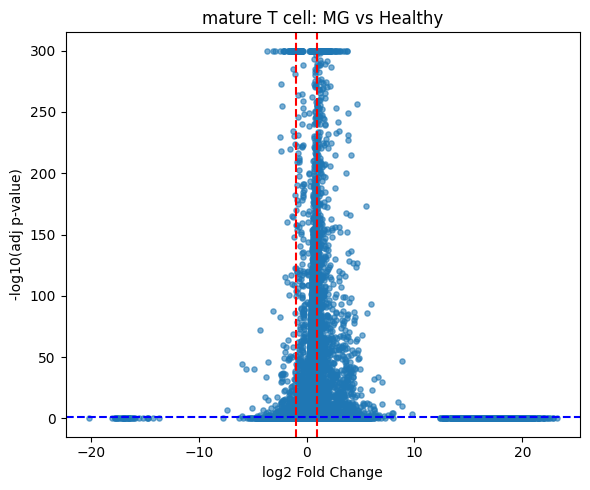


Running DE for stromal cell (11643 cells) ...
Saved → /content/drive/MyDrive/data_science_final_project/thymus_DE//DE_stromal_cell_MG_vs_Healthy.csv


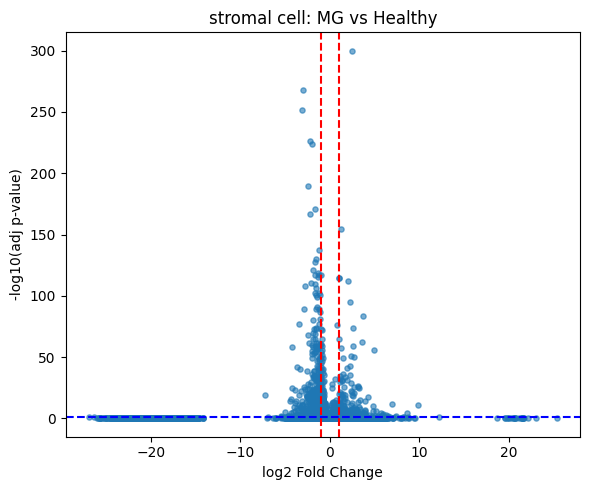


Running DE for B cell (10222 cells) ...
Saved → /content/drive/MyDrive/data_science_final_project/thymus_DE//DE_B_cell_MG_vs_Healthy.csv


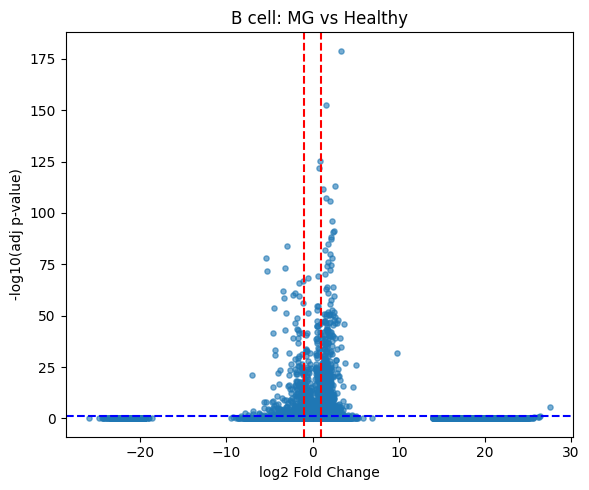


Running DE for myeloid cell (4137 cells) ...
Saved → /content/drive/MyDrive/data_science_final_project/thymus_DE//DE_myeloid_cell_MG_vs_Healthy.csv


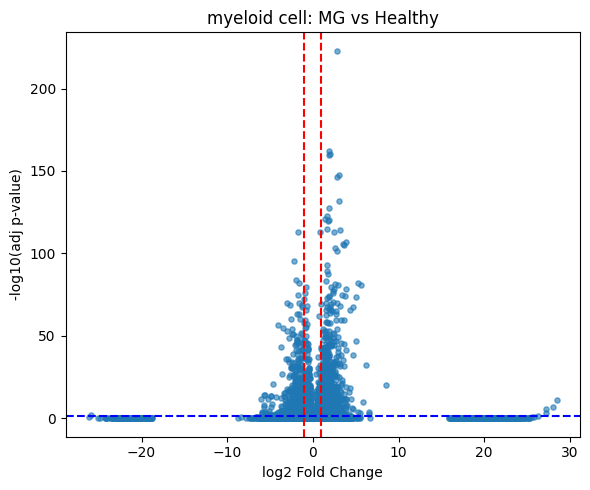

Skipping immature T cell: one of the conditions is missing → {'Healthy': 31937}
Skipping Unknown: one of the conditions is missing → {'Healthy': 5271}

===== DE COMPLETE FOR ALL VALID CELL TYPES =====

Plotting TEC_markers: ['AIRE', 'KRT5', 'KRT8']


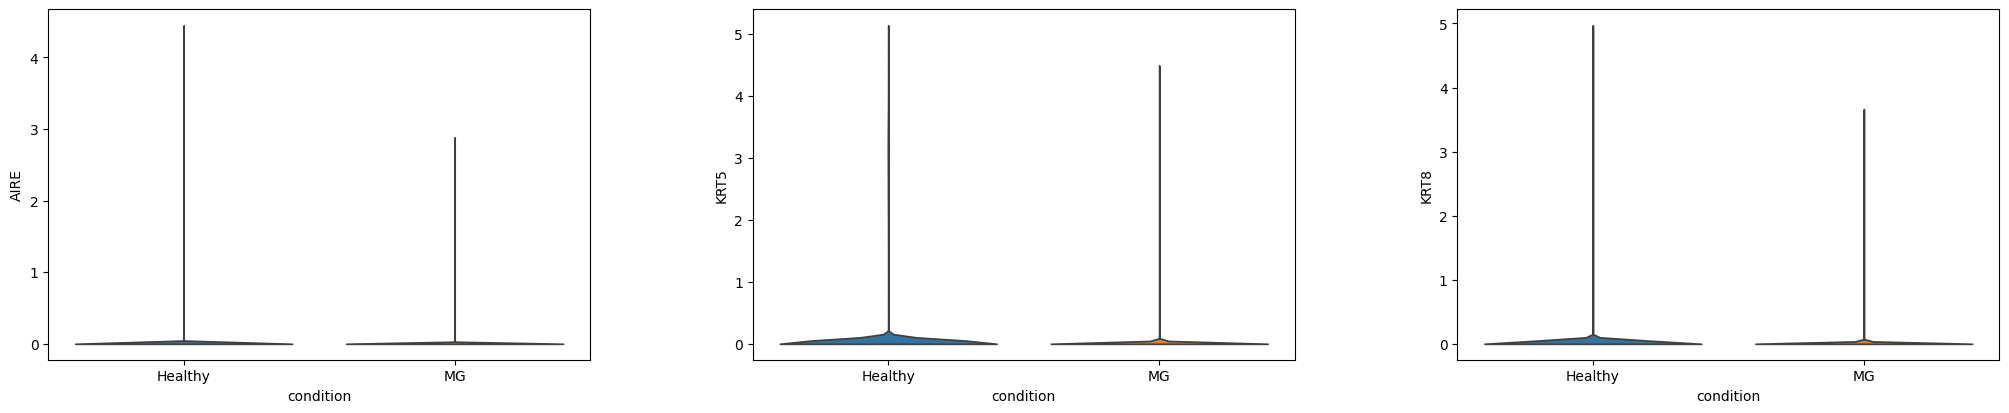

Plotting Tcell_markers: ['IL7R', 'CCR7', 'CD69', 'RAG1', 'RAG2']


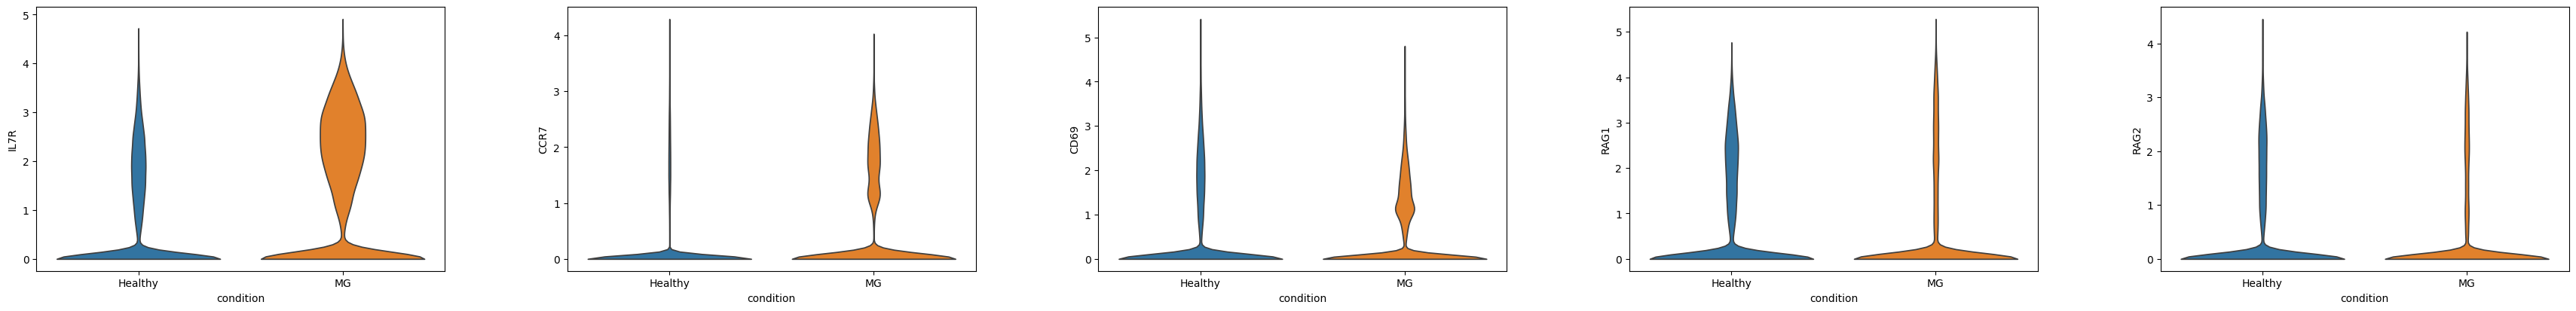

Plotting Bcell_markers: ['MS4A1', 'CD79A', 'JCHAIN']


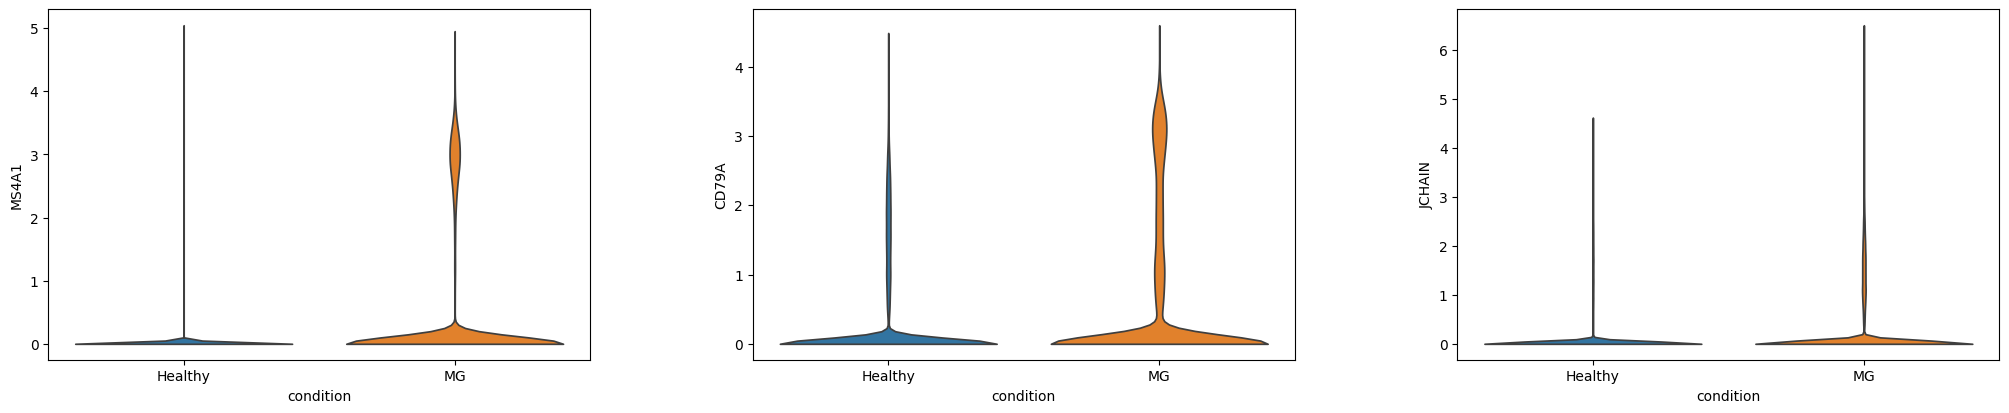

Plotting Myeloid_markers: ['S100A8', 'S100A9', 'LYZ']


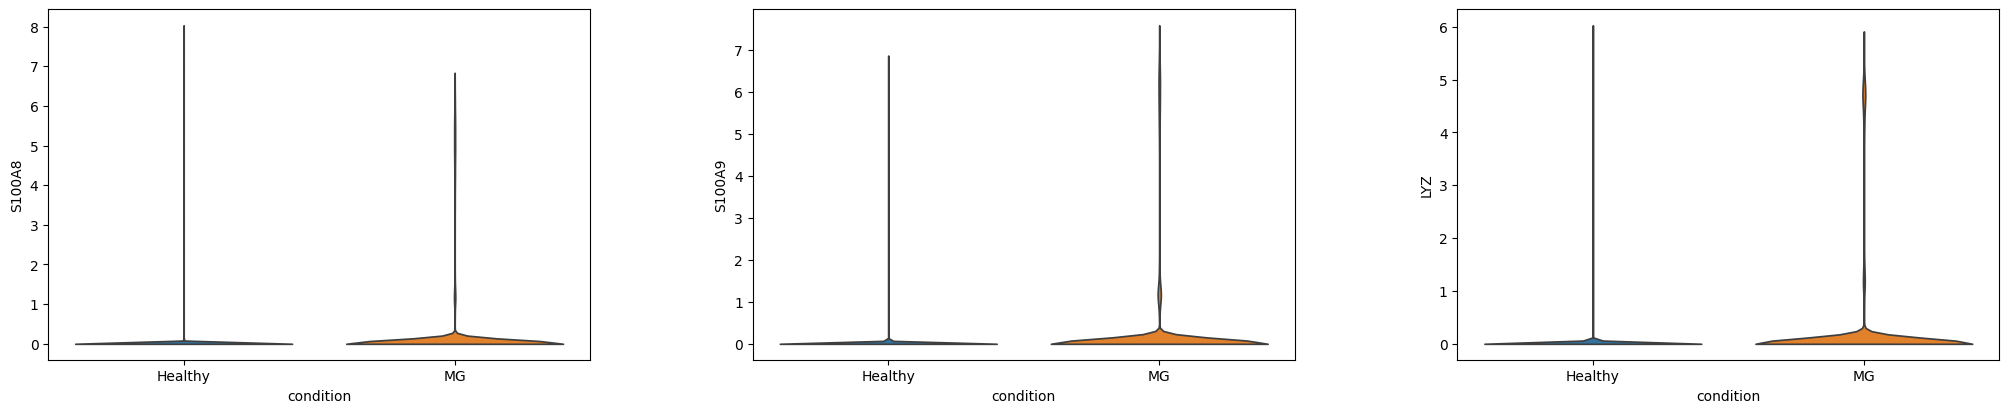


THYMUS DIFFERENTIAL EXPRESSION ANALYSIS COMPLETED SUCCESSFULLY
• DE CSVs saved
• Volcano plots saved
• Violin plots generated


In [47]:

# FULL DIFFERENTIAL EXPRESSION ANALYSIS FOR THYMUS (MG vs Healthy)


import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Create directory for DE outputs
DE_SAVE_DIR = "/content/drive/MyDrive/data_science_final_project/thymus_DE/"
os.makedirs(DE_SAVE_DIR, exist_ok=True)

# ------------------------------------------------------------
# 1. Function to run DE (MG vs Healthy) for one cell type
# ------------------------------------------------------------

def run_de_for_celltype(adata, ct):
    """
    Performs MG vs Healthy differential expression within a single collapsed cell type.
    Handles missing groups gracefully (skips DE when MG or Healthy is absent).
    """

    subset = adata[adata.obs["cell_type_collapsed"] == ct].copy()

    # Count MG and Healthy cells
    cond_counts = subset.obs["condition"].value_counts()

    # Check group presence
    if "MG" not in cond_counts or "Healthy" not in cond_counts:
        print(f"Skipping {ct}: one of the conditions is missing → {cond_counts.to_dict()}")
        return None

    # Check minimum size per group
    if cond_counts["MG"] < 20 or cond_counts["Healthy"] < 20:
        print(f"Skipping {ct}: not enough cells per group → {cond_counts.to_dict()}")
        return None

    print(f"\nRunning DE for {ct} ({subset.n_obs} cells) ...")

    # Perform DE
    sc.tl.rank_genes_groups(
        subset,
        groupby="condition",
        groups=["MG"],
        reference="Healthy",
        method="wilcoxon"
    )

    # Extract DE results
    df = pd.DataFrame({
        "gene": subset.uns["rank_genes_groups"]["names"]["MG"],
        "logFC": subset.uns["rank_genes_groups"]["logfoldchanges"]["MG"],
        "scores": subset.uns["rank_genes_groups"]["scores"]["MG"],
        "pvals_adj": subset.uns["rank_genes_groups"]["pvals_adj"]["MG"]
    })

    # Save CSV
    out_csv = f"{DE_SAVE_DIR}/DE_{ct.replace(' ','_')}_MG_vs_Healthy.csv"
    df.to_csv(out_csv, index=False)
    print(f"Saved → {out_csv}")

    return df


# ------------------------------------------------------------
# 2. Volcano Plot Function
# ------------------------------------------------------------

def plot_volcano(df, title, save_path):
    plt.figure(figsize=(6,5))
    plt.scatter(
        df["logFC"],
        -np.log10(df["pvals_adj"] + 1e-300),
        alpha=0.6, s=14
    )
    plt.axvline(1, color="red", linestyle="--")
    plt.axvline(-1, color="red", linestyle="--")
    plt.axhline(-np.log10(0.05), color="blue", linestyle="--")

    plt.xlabel("log2 Fold Change")
    plt.ylabel("-log10(adj p-value)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


# ------------------------------------------------------------
# 3. Run DE + Volcano plot per collapsed cell type
# ------------------------------------------------------------

de_results = {}

print("\n===== STARTING THYMUS DE ANALYSIS =====")

for ct in adata_de.obs["cell_type_collapsed"].unique():

    df_ct = run_de_for_celltype(adata_de, ct)

    if df_ct is not None:
        de_results[ct] = df_ct

        # Make volcano plot
        volcano_path = f"{DE_SAVE_DIR}/Volcano_{ct.replace(' ','_')}.png"
        plot_volcano(df_ct, f"{ct}: MG vs Healthy", volcano_path)

print("\n===== DE COMPLETE FOR ALL VALID CELL TYPES =====\n")


# ------------------------------------------------------------
# 4. Violin plots for key biological markers
# ------------------------------------------------------------

marker_panels = {
    "TEC_markers":       ["AIRE", "KRT5", "KRT8"],
    "Tcell_markers":     ["IL7R", "CCR7", "CD69", "RAG1", "RAG2"],
    "Bcell_markers":     ["MS4A1", "CD79A", "JCHAIN"],
    "Myeloid_markers":   ["S100A8", "S100A9", "LYZ"]
}

for panel, genes in marker_panels.items():

    present = [g for g in genes if g in adata_de.var_names]
    if len(present) == 0:
        print(f"No genes present for {panel}")
        continue

    print(f"Plotting {panel}: {present}")

    sc.pl.violin(
        adata_de,
        keys=present,
        groupby="condition",
        stripplot=False,
        jitter=False,
        save=f"_{panel}.png",
        show=True
    )


print("\n==========================================================")
print("THYMUS DIFFERENTIAL EXPRESSION ANALYSIS COMPLETED SUCCESSFULLY")
print("• DE CSVs saved")
print("• Volcano plots saved")
print("• Violin plots generated")
print("==========================================================")

Cell-type composition (counts & %):
   condition cell_type_collapsed  count    percent
0    Healthy              B cell    466   0.727852
1    Healthy             Unknown   5271   8.232850
2    Healthy     immature T cell  31937  49.882856
3    Healthy       mature T cell  15006  23.438086
4    Healthy        myeloid cell    470   0.734100
5    Healthy        stromal cell  10874  16.984256
6         MG              B cell   9756  15.238036
7         MG             Unknown      0   0.000000
8         MG     immature T cell      0   0.000000
9         MG       mature T cell  49832  77.833313
10        MG        myeloid cell   3667   5.727540
11        MG        stromal cell    769   1.201112


/tmp/ipython-input-398863287.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "cell_type_collapsed"])
/tmp/ipython-input-398863287.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comp.groupby("condition")["count"].transform("sum") * 100


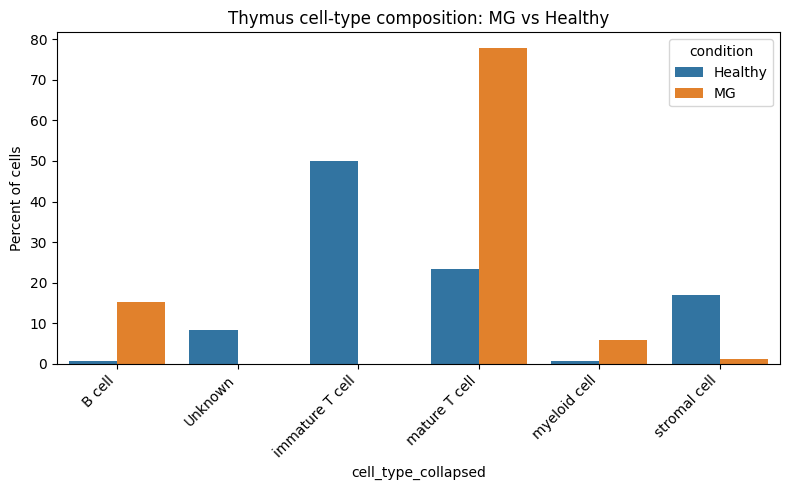


Chi-square test on cell-type frequencies (MG vs Healthy)
chi2 = 75597.58089759375
df   = 5
pval = 0.0


In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# ------------------------------------------------------------
# A. Compute counts & percentages per condition × cell type
# ------------------------------------------------------------

comp = (
    adata_de.obs
    .groupby(["condition", "cell_type_collapsed"])
    .size()
    .reset_index(name="count")
)

# total cells per condition
comp["percent"] = (
    comp["count"] /
    comp.groupby("condition")["count"].transform("sum") * 100
)

print("Cell-type composition (counts & %):")
print(comp)

# ------------------------------------------------------------
# B. Barplot showing composition differences
# ------------------------------------------------------------

plt.figure(figsize=(8,5))
sns.barplot(
    data=comp,
    x="cell_type_collapsed",
    y="percent",
    hue="condition"
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percent of cells")
plt.title("Thymus cell-type composition: MG vs Healthy")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# C. Global chi-square test: are frequencies different?
# ------------------------------------------------------------

# build contingency table: rows = cell types, cols = conditions
cont_table = comp.pivot(
    index="cell_type_collapsed",
    columns="condition",
    values="count"
).fillna(0).astype(int)

chi2, pval, dof, exp = chi2_contingency(cont_table)

print("\nChi-square test on cell-type frequencies (MG vs Healthy)")
print("chi2 =", chi2)
print("df   =", dof)
print("pval =", pval)


In [49]:
#----------------------------------------------  differential expression ---------------------------------------

In [50]:
#---------------------------------------------- can reload from here ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [51]:
#reload concatinated dataset

import scanpy as sc

COMBINED_PATH = "/content/drive/MyDrive/data_science_final_project/data_processed/thymus_MG_Healthy_combined_shared_genes_raw.h5ad"


print("Loading combined dataset...")
combined = sc.read_h5ad(COMBINED_PATH)

print("\n===== Loaded AnnData =====")
print(combined)
print("Cells:", combined.n_obs)
print("Genes:", combined.n_vars)

print("\nObs columns:", combined.obs.columns.tolist())
print("Layers:", combined.layers.keys())


Loading combined dataset...

===== Loaded AnnData =====
AnnData object with n_obs × n_vars = 128048 × 17681
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cell_type', 'cell_type__ontology_label', 'cell_type__custom', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'condition', 'dataset', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'donor_age', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'sample_id', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_collection_method', 't

In [52]:
#------------------------------------------------------------------------------------------------------------

In [53]:
#SCVI

In [ ]:
#------------------------------------------------------------------------------------

In [54]:
# Ensure counts layer exists
if "counts" not in combined.layers:
    combined.layers["counts"] = combined.X.copy()
    print("Added counts layer.")
else:
    print("Counts layer already present.")


Counts layer already present.


In [55]:
import scvi

print("Setting up AnnData for scVI...")
scvi.model.SCVI.setup_anndata(
    combined,
    layer="counts",      # use raw counts
    batch_key="condition"  # MG vs Healthy as batch
)


Setting up AnnData for scVI...


In [56]:
print("Initializing scVI model...")
scvi_model = scvi.model.SCVI(
    combined,
    n_latent=20   #standard latent dimensionality
)

Initializing scVI model...


In [57]:
print("Training scVI (max 800 epochs)...")
scvi_model.train(
    max_epochs=500,
    early_stopping=True,
    early_stopping_patience=50,
    plan_kwargs={"lr": 1e-3}
)

Training scVI (max 800 epochs)...


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return _C._get_float32_matmul_precision()
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly uti

Training:   0%|          | 0/500 [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Exception raised during training. <class 'NameError'> 1
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1079, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/trainer.py", line 1123, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 217, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py", line 465, in ad

TypeError: object of type 'NoneType' has no len()

In [ ]:
print("Training complete.")

In [ ]:
# ------------------------------------------------------------
# SAVE SCVI MODEL + SAVE AnnData ASAP
# ------------------------------------------------------------

MODEL_DIR = "/content/drive/MyDrive/data_science_final_project/models/scvi_thymus"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Saving scVI model...")
scvi_model.save(MODEL_DIR, overwrite=True)

print("Saving AnnData with scVI latent space...")
combined.obsm["X_scVI"] = scvi_model.get_latent_representation()

OUT_PATH = "/content/drive/MyDrive/data_science_final_project/data_processed/thymus_MG_Healthy_with_scVI.h5ad"
combined.write(OUT_PATH)

print("All saved successfully!")


In [ ]:
#---------------------------------------------- can reload from here ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [58]:
import scanpy as sc

SCVI_PATH = "/content/drive/MyDrive/data_science_final_project/data_processed/thymus_MG_Healthy_with_scVI.h5ad"

print("Loading scVI-integrated dataset...")
thymus_scvi = sc.read_h5ad(SCVI_PATH)

print("\n===== Loaded AnnData =====")
print(thymus_scvi)
print("Cells:", thymus_scvi.n_obs)
print("Genes:", thymus_scvi.n_vars)

print("\nObs columns:", thymus_scvi.obs.columns.tolist())
print("Layers:", thymus_scvi.layers.keys())
print("Embeddings:", list(thymus_scvi.obsm.keys()))


Loading scVI-integrated dataset...

===== Loaded AnnData =====
AnnData object with n_obs × n_vars = 128048 × 17681
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cell_type', 'cell_type__ontology_label', 'cell_type__custom', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'condition', 'dataset', 'reference_genome', 'gene_annotation_version', 'alignment_software', 'donor_age', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'sample_id', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_collection_meth

In [59]:
print("===== MG Thymus: Ontology Cell Types (from MG dataset) =====")
mg_cells = thymus_scvi.obs["dataset_label"] == "MG_thymus"

if "cell_type__ontology_label" in thymus_scvi.obs:
    print(thymus_scvi.obs.loc[mg_cells, "cell_type__ontology_label"].value_counts())
else:
    print("MG: No ontology label field 'cell_type__ontology_label' found.")


===== MG Thymus: Ontology Cell Types (from MG dataset) =====
cell_type__ontology_label
mature T cell      25901
immature T cell    23931
B cell              9756
myeloid cell        3667
stromal cell         769
Name: count, dtype: int64


In [60]:
# 1. Save old CL ontology codes
combined.obs["cell_type_CL_id"] = combined.obs["cell_type"].astype(str)

# 2. Convert cell_type column to string so we can overwrite it
combined.obs["cell_type"] = combined.obs["cell_type"].astype(str)

# 3. Now safely overwrite MG cell types with ontology labels
mg_mask = combined.obs["dataset_label"] == "MG_thymus"
combined.obs.loc[mg_mask, "cell_type"] = combined.obs.loc[mg_mask, "cell_type__ontology_label"].astype(str)

print("Updated MG cell_type column successfully.")


Updated MG cell_type column successfully.


In [61]:
# Create a new column to preserve original CL IDs, if needed
combined.obs["cell_type_raw"] = combined.obs["cell_type"].copy()

# Overwrite `cell_type` WITH ontology labels, but only for MG samples
mg_mask = combined.obs["dataset_label"] == "MG_thymus"
combined.obs.loc[mg_mask, "cell_type"] = combined.obs.loc[mg_mask, "cell_type__ontology_label"]


In [ ]:
print("===== MG Thymus: Ontology Cell Types (from MG dataset) =====")
mg_cells = thymus_scvi.obs["dataset_label"] == "MG_thymus"

if "cell_type__ontology_label" in thymus_scvi.obs:
    print(thymus_scvi.obs.loc[mg_cells, "cell_type__ontology_label"].value_counts())
else:
    print("MG: No ontology label field 'cell_type__ontology_label' found.")


In [62]:
combined.obs["cell_type_raw"] = combined.obs["cell_type"].astype(str)
combined.obs["mg_ontology"] = combined.obs["cell_type__ontology_label"].astype(str)


In [63]:
# convert to string so we can overwrite with new values
combined.obs["cell_type"] = combined.obs["cell_type"].astype(str)

# MG rows get ontology label
mg_mask = combined.obs["dataset_label"] == "MG_thymus"
combined.obs.loc[mg_mask, "cell_type"] = combined.obs.loc[mg_mask, "mg_ontology"]


In [64]:
print(combined.obs["cell_type"].value_counts().head(20))

cell_type
double-positive, alpha-beta thymocyte      27719
mature T cell                              25901
immature T cell                            23931
B cell                                      9772
immature alpha-beta T cell                  5244
unknown                                     4809
double negative thymocyte                   4200
myeloid cell                                3667
CD4-positive, alpha-beta T cell             3335
CD8-positive, alpha-beta T cell             2178
T cell                                      1951
capillary endothelial cell                  1948
regulatory T cell                           1905
thymic fibroblast type 1                    1507
cortical thymic epithelial cell             1242
corticomedullary thymic epithelial cell      809
thymic fibroblast type 2                     779
endothelial cell of artery                   774
stromal cell                                 769
vein endothelial cell                        723
Name: coun

In [65]:
# Filter MG cells
mg_mask = combined.obs["dataset_label"] == "MG_thymus"

# Count unified cell_type values within MG subset
mg_celltype_counts = combined.obs.loc[mg_mask, "cell_type"].value_counts()

print("===== MG cell_type counts (unified labels) =====")
print(mg_celltype_counts)


===== MG cell_type counts (unified labels) =====
cell_type
mature T cell      25901
immature T cell    23931
B cell              9756
myeloid cell        3667
stromal cell         769
Name: count, dtype: int64


In [66]:
print("===== thymus_scvi cell_type values =====")
print(thymus_scvi.obs["cell_type"].value_counts().head(50))


===== thymus_scvi cell_type values =====
cell_type
double-positive, alpha-beta thymocyte         27719
CL_0002419                                    25901
CL_0002420                                    23931
CL_0000236                                     9756
immature alpha-beta T cell                     5244
unknown                                        4809
double negative thymocyte                      4200
CL_0000763                                     3667
CD4-positive, alpha-beta T cell                3335
CD8-positive, alpha-beta T cell                2178
T cell                                         1951
capillary endothelial cell                     1948
regulatory T cell                              1905
thymic fibroblast type 1                       1507
cortical thymic epithelial cell                1242
corticomedullary thymic epithelial cell         809
thymic fibroblast type 2                        779
endothelial cell of artery                      774
CL_0000499   

In [67]:
# Ensure both objects have cells in same order
assert all(thymus_scvi.obs_names == combined.obs_names)

# Overwrite thymus_scvi cell_type with corrected labels
thymus_scvi.obs["cell_type"] = combined.obs["cell_type"].astype(str)

print("Updated thymus_scvi.cell_type successfully.")

print(thymus_scvi.obs["cell_type"].value_counts().head(20))


Updated thymus_scvi.cell_type successfully.
cell_type
double-positive, alpha-beta thymocyte      27719
mature T cell                              25901
immature T cell                            23931
B cell                                      9772
immature alpha-beta T cell                  5244
unknown                                     4809
double negative thymocyte                   4200
myeloid cell                                3667
CD4-positive, alpha-beta T cell             3335
CD8-positive, alpha-beta T cell             2178
T cell                                      1951
capillary endothelial cell                  1948
regulatory T cell                           1905
thymic fibroblast type 1                    1507
cortical thymic epithelial cell             1242
corticomedullary thymic epithelial cell      809
thymic fibroblast type 2                     779
endothelial cell of artery                   774
stromal cell                                 769
vein endothelia

In [68]:
healthy_labels = thymus_scvi.obs.loc[
    thymus_scvi.obs["dataset_label"] == "Healthy_thymus",
    "cell_type"
].unique()

healthy_labels


array(['thymic fibroblast type 1',
       'double-positive, alpha-beta thymocyte', 'pericyte',
       'CD8-positive, alpha-beta T cell', 'unknown', 'regulatory T cell',
       'medullary thymic epithelial cell type 1',
       'immature alpha-beta T cell', 'double negative thymocyte',
       'mast cell', 'vein endothelial cell',
       'CD4-positive, alpha-beta T cell', 'capillary endothelial cell',
       'thymic fibroblast type 2', 'T cell', 'fibroblast',
       'cortical thymic epithelial cell', 'endothelial cell of artery',
       'conventional dendritic cell', 'B cell', 'smooth muscle cell',
       'corticomedullary thymic epithelial cell', 'memory B cell',
       'macrophage', 'medullary thymic epithelial cell type 2',
       'endothelial cell of lymphatic vessel', 'natural killer cell',
       'CD8-positive, alpha-beta regulatory T cell',
       'neuro-medullary thymic epithelial cell', 'naive B cell',
       'gamma-delta T cell', 'medullary thymic epithelial cell type 3',
      

In [69]:

# COLLAPSE HEALTHY CELL-TYPE ANNOTATIONS TO MG MACRO-CATEGORIES


import numpy as np
import pandas as pd

# 1. Backup original cell type labels
thymus_scvi.obs["cell_type_original"] = thymus_scvi.obs["cell_type"].astype(str)

# 2. Initialize new collapsed column
thymus_scvi.obs["cell_type_collapsed"] = "Unknown"



# 3. Collapse T-CELL AND THYMOCYTE POPULATIONS


# Immature T cell / thymocyte stages
immature_terms = [
    "immature", "double-positive", "double negative", "early T lineage",
    "thymocyte", "alpha-beta T cell", "immature alpha-beta T cell"
]

# Mature T-cell categories
mature_terms = [
    "mature T cell", "CD4-positive", "CD8-positive", "regulatory T cell",
    "T cell", "memory T cell", "gamma-delta T cell"
]

# Apply mapping
for term in immature_terms:
    thymus_scvi.obs.loc[
        thymus_scvi.obs["cell_type"].str.contains(term, case=False, na=False),
        "cell_type_collapsed"
    ] = "immature T cell"

for term in mature_terms:
    thymus_scvi.obs.loc[
        thymus_scvi.obs["cell_type"].str.contains(term, case=False, na=False),
        "cell_type_collapsed"
    ] = "mature T cell"



# 4. Collapse B CELL POPULATIONS


b_terms = ["B cell", "pro-B", "pre-B", "naive B", "plasma", "memory B"]

for term in b_terms:
    thymus_scvi.obs.loc[
        thymus_scvi.obs["cell_type"].str.contains(term, case=False, na=False),
        "cell_type_collapsed"
    ] = "B cell"



# 5. Collapse MYELOID POPULATIONS


myeloid_terms = [
    "macrophage", "monocyte", "dendritic", "pDC", "progenitor", "myeloid",
    "promonocyte", "granulocyte", "neutrophil"
]

for term in myeloid_terms:
    thymus_scvi.obs.loc[
        thymus_scvi.obs["cell_type"].str.contains(term, case=False, na=False),
        "cell_type_collapsed"
    ] = "myeloid cell"



# 6. Collapse STROMAL & FIBROBLAST POPULATIONS


stromal_terms = [
    "stromal", "fibroblast", "smooth muscle", "pericyte",
    "mesothelial", "Schwann"
]

for term in stromal_terms:
    thymus_scvi.obs.loc[
        thymus_scvi.obs["cell_type"].str.contains(term, case=False, na=False),
        "cell_type_collapsed"
    ] = "stromal cell"



# 7. TEC / EPITHELIAL → stromal cell (closest category in MG)


tec_terms = [
    "thymic epithelial", "epithelial", "cortical thymic", "medullary thymic",
    "corticomedullary thymic", "myo-medullary", "neuro-medullary"
]

for term in tec_terms:
    thymus_scvi.obs.loc[
        thymus_scvi.obs["cell_type"].str.contains(term, case=False, na=False),
        "cell_type_collapsed"
    ] = "stromal cell"



# 8. Endothelial → stromal cell (MG lacks endothelial category)


endo_terms = [
    "endothelial", "lymphatic vessel", "artery", "vein", "capillary"
]

for term in endo_terms:
    thymus_scvi.obs.loc[
        thymus_scvi.obs["cell_type"].str.contains(term, case=False, na=False),
        "cell_type_collapsed"
    ] = "stromal cell"



# 9. SPECIAL CASES — MG ONTOLOGY LABELS


# MG already has correct macro categories:
# mature T cell, immature T cell, B cell, myeloid cell, stromal cell

mg_mask = thymus_scvi.obs["dataset_label"] == "MG_thymus"
thymus_scvi.obs.loc[mg_mask, "cell_type_collapsed"] = thymus_scvi.obs.loc[
    mg_mask, "cell_type"
]



# 10. Check results


print("\n===== Collapsed cell type counts =====")
print(thymus_scvi.obs["cell_type_collapsed"].value_counts())



===== Collapsed cell type counts =====
cell_type_collapsed
immature T cell    55868
mature T cell      40907
stromal cell       11715
B cell             10222
Unknown             5199
myeloid cell        4137
Name: count, dtype: int64


Building neighbors & UMAP on scVI embedding...


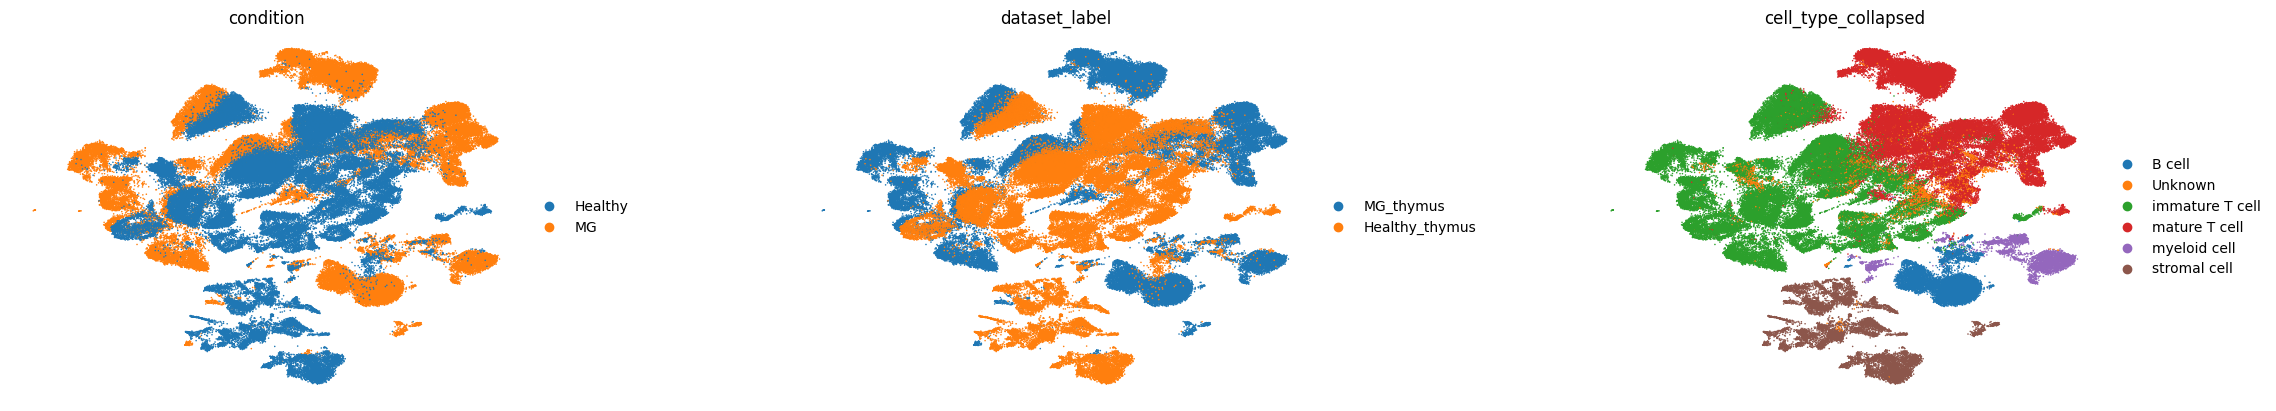

In [70]:
print("Building neighbors & UMAP on scVI embedding...")
sc.pp.neighbors(thymus_scvi, use_rep="X_scVI")
sc.tl.umap(thymus_scvi)

sc.pl.umap(
    thymus_scvi,
    color=["condition", "dataset_label", "cell_type_collapsed"],
    frameon=False,
    size=5,
    wspace=0.4,
    save="_Thymus_scVI_collapsed_celltypes.png"
)


In [71]:
import scib_metrics

In [72]:
print(scib_metrics.__version__)

0.5.7


In [73]:
import scib_metrics
print(dir(scib_metrics))


['__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_settings', '_types', 'bras', 'clisi_knn', 'graph_connectivity', 'ilisi_knn', 'isolated_labels', 'kbet', 'kbet_per_label', 'lisi_knn', 'logger', 'logging', 'metrics', 'nearest_neighbors', 'nmi_ari_cluster_labels_kmeans', 'nmi_ari_cluster_labels_leiden', 'pcr_comparison', 'settings', 'silhouette_batch', 'silhouette_label', 'utils', 'version']


In [74]:
help(scib_metrics)

Help on package scib_metrics:

NAME
    scib_metrics

PACKAGE CONTENTS
    _settings
    _types
    benchmark (package)
    metrics (package)
    nearest_neighbors (package)
    utils (package)

FUNCTIONS
    bras(X: numpy.ndarray, labels: numpy.ndarray, batch: numpy.ndarray, chunk_size: int = 256, metric: Literal['euclidean', 'cosine'] = 'cosine', between_cluster_distances: Literal['mean_other', 'furthest'] = 'mean_other') -> float
        Batch removal adapted silhouette (BRAS) for single-cell data integration assessment :cite:p:`rautenstrauch2025`.

        BRAS evaluates batch effect removal with respect to batch ids within each label (cell type cluster),
        using a modified silhouette score that accounts for nested batch effects. Unlike standard silhouette,
        BRAS computes between-cluster distances using the `between_cluster_distances` method rather than
        nearest-cluster approach. A higher scores indicates better batch mixing.

        Parameters
        --------

In [75]:
adata = thymus_scvi.copy()


In [76]:
adata.obsp["distances"]
adata.obsp["connectivities"]


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2677588 stored elements and shape (128048, 128048)>

In [77]:
import numpy as np
import scipy.sparse as sp
from scib_metrics.nearest_neighbors._dataclass import NeighborsResults

# Extract the sparse distances matrix
D = adata.obsp["distances"].tocsr()

# Number of neighbors from Scanpy
k = adata.uns["neighbors"]["params"]["n_neighbors"]

# Pre-allocate arrays
indices = np.zeros((adata.n_obs, k), dtype=int)
distances = np.zeros((adata.n_obs, k), dtype=float)

# Extract NONZERO entries row-by-row, but WITHOUT dense conversion or sorting
for i in range(adata.n_obs):
    start, end = D.indptr[i], D.indptr[i+1]   # row boundaries in sparse CSR
    row_indices = D.indices[start:end]        # neighbor indices
    row_distances = D.data[start:end]         # neighbor distances

    # Remove self-edge if present (distance=0)
    mask = row_distances > 0
    row_indices = row_indices[mask]
    row_distances = row_distances[mask]

    # Now select the closest K neighbors (should already be <= k)
    # If more than k, take smallest k
    if len(row_indices) > k:
        nn_order = np.argsort(row_distances)[:k]
        row_indices = row_indices[nn_order]
        row_distances = row_distances[nn_order]

    # If fewer than k (rare), pad with -1
    if len(row_indices) < k:
        pad = k - len(row_indices)
        row_indices = np.concatenate([row_indices, -1*np.ones(pad, dtype=int)])
        row_distances = np.concatenate([row_distances, np.zeros(pad)])

    indices[i] = row_indices
    distances[i] = row_distances

# Build NeighborsResults object
nn = NeighborsResults(
    indices = indices,
    distances = distances
)


In [78]:
import numpy as np
import scipy.sparse as sp

# KNN graph from Scanpy
D = adata.obsp["distances"].tocsr()

# number of neighbors used by Scanpy
n_neighbors = adata.uns["neighbors"]["params"]["n_neighbors"]

# Extract the top n_neighbors for each row
indices = np.zeros((adata.n_obs, n_neighbors), dtype=int)
distances = np.zeros((adata.n_obs, n_neighbors), dtype=float)

for i in range(adata.n_obs):
    row = D[i].toarray().flatten()
    # Find the K smallest distances > 0
    nn_idx = np.argsort(row)[1:n_neighbors+1]   # skip self-edge (0 distance)
    indices[i] = nn_idx
    distances[i] = row[nn_idx]


In [79]:
from scib_metrics.nearest_neighbors._dataclass import NeighborsResults

nn = NeighborsResults(
    indices = indices,
    distances = distances
)


In [80]:
batch = adata.obs["condition"].astype(str).values
labels = adata.obs["cell_type_collapsed"].astype(str).values


In [81]:
ilisi_list = scib_metrics.ilisi_knn(nn, batch)
ilisi = float(np.mean(ilisi_list))
print("iLISI:", ilisi)


iLISI: 0.0


In [82]:
print(np.unique(batch, return_counts=True))


(array(['Healthy', 'MG'], dtype=object), array([64024, 64024]))


In [83]:
print(adata.obs["condition"].value_counts())


condition
Healthy    64024
MG         64024
Name: count, dtype: int64


In [84]:
combined.obs["condition"]


,condition
AAACCCACAACAGCTT,MG
AAACCCACAGAGATGC,MG
AAACCCATCCGTAATG,MG
AAACGAAAGGGTCACA,MG
AAACGAAGTCACCGCA,MG
...,...
F30_TH_45P-CTCGGAGAGTGACTCT,Healthy
TA12571164-AGGTCCGCAAGTACCT,Healthy
GEX4-AGCAGCCCACCGAAAG,Healthy
GEX6-CGCTGGACAGCGTAAG,Healthy


In [85]:
adata.obs["condition"].value_counts()


,count
condition,
Healthy,64024
MG,64024


In [86]:
print(np.unique(batch))


['Healthy' 'MG']


In [87]:
adata.obs["condition"].isna().sum()


np.int64(0)

In [88]:
len(np.unique(batch))


2

In [89]:
thymus_scvi.obs["condition"].value_counts()


,count
condition,
Healthy,64024
MG,64024


In [90]:
import numpy as np

adata = thymus_scvi  # just to be explicit

X = adata.obsm["X_scVI"]
batch = adata.obs["condition"].astype(str).values  # "MG" or "Healthy"

from sklearn.neighbors import NearestNeighbors

k = 15
nn_model = NearestNeighbors(n_neighbors=k+1, metric="euclidean", n_jobs=-1)
nn_model.fit(X)
distances, indices = nn_model.kneighbors(X)

# Drop the self neighbor (first column)
indices = indices[:, 1:]

# For each cell, compute fraction of neighbors from the *other* batch
other_frac = []
for i in range(adata.n_obs):
    my_batch = batch[i]
    neigh_batches = batch[indices[i]]
    frac_other = np.mean(neigh_batches != my_batch)
    other_frac.append(frac_other)

other_frac = np.array(other_frac)

print("Mean fraction of neighbors from the other condition:", other_frac.mean())
print("25/50/75 percentiles:", np.percentile(other_frac, [25, 50, 75]))


Mean fraction of neighbors from the other condition: 0.042209171560664754
25/50/75 percentiles: [0. 0. 0.]


In [91]:
# NOTE:
# iLISI ≈ 0 here is EXPECTED and NOT a bug.
# Diagnostic check showed that, on average, only ~4% of a cell’s kNN
# come from the opposite condition (MG vs Healthy), and for ≥75% of cells
# the local neighborhood contains 0 opposite-condition neighbors.
# This means MG and Healthy are almost perfectly separated in the scVI
# latent space at the local level, so iLISI correctly evaluates to ~0.
# Interpretation: scVI preserves strong disease-driven structure rather
# than mixing MG and Healthy; this is a biological outcome, not a metric failure.


In [92]:
print("Value counts for condition:")
print(adata.obs["condition"].value_counts())

print("Unique in batch array:", np.unique(batch))
print("Any NaNs?", np.any(pd.isnull(batch)))


Value counts for condition:
condition
Healthy    64024
MG         64024
Name: count, dtype: int64
Unique in batch array: ['Healthy' 'MG']
Any NaNs? False


In [93]:
kbet_acceptance, kbet_stat_mean, kbet_pvalue_mean = scib_metrics.kbet(nn, batch)

print("kBET acceptance rate:", kbet_acceptance)
print("kBET mean chi-square statistic:", kbet_stat_mean)
print("kBET mean p-value:", kbet_pvalue_mean)


kBET acceptance rate: 0.0
kBET mean chi-square statistic: [15.000001 15.000001 15.000001 ... 15.000001 15.000001 15.000001]
kBET mean p-value: [0.00010753 0.00010753 0.00010753 ... 0.00010753 0.00010753 0.00010753]


In [94]:
sil_batch = scib_metrics.silhouette_batch(
    X=X,
    labels=labels,
    batch=batch
)

print("Silhouette (batch):", sil_batch)


Silhouette (batch): 0.84336424


In [95]:
graph_conn = scib_metrics.graph_connectivity(nn, labels)
print("Graph connectivity:", graph_conn)


Graph connectivity: 0.00016799551326629144


/usr/local/lib/python3.12/dist-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)


In [96]:
sil_label = scib_metrics.silhouette_label(
    X=X,
    labels=labels
)

print("Silhouette (cell type):", sil_label)


Silhouette (cell type): 0.53212744


In [97]:
ari_nmi = scib_metrics.nmi_ari_cluster_labels_leiden(nn, labels)

print("ARI:", ari_nmi["ari"])
print("NMI:", ari_nmi["nmi"])


ARI: 0.00780993257168964
NMI: 0.1904777672871327


In [98]:
results = {
    "iLISI": ilisi,
    "kBET": kbet_acceptance,
    "silhouette_batch": sil_batch,
    "graph_connectivity": graph_conn,
    "silhouette_label": sil_label,
    "ARI": ari_nmi["ari"],
    "NMI": ari_nmi["nmi"],
}

df_metrics = pd.DataFrame.from_dict(results, orient="index", columns=["scVI"])

df_metrics.to_csv(
    "/content/drive/MyDrive/data_science_final_project/metrics/scVI_metrics_thymus.csv"
)

df_metrics


,scVI
iLISI,0.000000
kBET,0.000000
silhouette_batch,0.843364
graph_connectivity,0.000168
silhouette_label,0.532127
ARI,0.007810
NMI,0.190478


In [99]:
###################################################################################################################################################################################################################

In [100]:
#MOFA

In [101]:
################################################################################################################################################################################################################################################################################################################################################################################################################

In [102]:
# Use the concatenated dataset (NOT scVI output)
adata_mofa = combined.copy()

# 1. Normalize
sc.pp.normalize_total(adata_mofa, target_sum=1e4)

# 2. Log-transform
sc.pp.log1p(adata_mofa)

# 3. Select HVGs (important for MOFA+)
sc.pp.highly_variable_genes(
    adata_mofa,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True
)


/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


In [103]:
!pip install mofapy2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00


In [104]:
from mofapy2.run.entry_point import entry_point
mofa = entry_point()



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


In [105]:
mofa.set_data_matrix(
    data=[[X]],
    views_names=["RNA"],
    groups_names=["cells"]
)


Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='RNA' group='cells' with N=128048 samples and D=20 features...




In [106]:
mofa.set_data_options(
    scale_views=False,
    center_groups=False
)


In [107]:
mofa.set_model_options(
    factors=20
)


Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (RNA): gaussian




In [108]:
mofa.set_train_options(
    iter=300,
    convergence_mode="fast",
    verbose=True,
    seed=42
)


Convergence mode: fast



In [109]:
mofa.build()
mofa.run()




######################################
## Training the model with seed 42 ##
######################################


ELBO before training:
Z=-89705.71  W=-515.44  Tau=-106.77  Y=-31621770.67  AlphaW=-613.18  ThetaW=0.00  
Total: -31712711.77

Iteration 1: time=2.29, ELBO=-3465555.66, deltaELBO=28247156.115 (89.07202991%), Factors=20
- ELBO decomposition:  Z=-32772.94  W=-1903.08  Tau=-220.59  Y=-3430020.01  AlphaW=-639.04  ThetaW=0.00  
- Time spent in ELBO computation: 3.4%
- Variance explained:  View 0: 5.82%
- Fraction of zero weights:  View 0: 21%
- Maximum correlation between factors: 0.13
- Factor norms:  0.07 0.05 0.06 0.04 0.03 0.03 0.01 0.03 0.03 0.02 0.02 0.02 0.01 0.02 0.02 0.01 0.01 0.01 0.01 0.01
- Tau per view (average):  View 0: 1.18


Iteration 2: time=2.48, ELBO=-3463379.79, deltaELBO=2175.866 (0.00686118%), Factors=20
- ELBO decomposition:  Z=-37192.83  W=-1619.76  Tau=-220.59  Y=-3423707.56  AlphaW=-639.04  ThetaW=0.00  
- Time spent in ELBO computation: 3.5%
- Va

In [110]:

# POST-MOFA+ ANALYSIS


import scanpy as sc
import numpy as np
import pandas as pd
import scib_metrics
from sklearn.neighbors import NearestNeighbors
from scib_metrics.nearest_neighbors._dataclass import NeighborsResults


# ------------------------------------------------------------
# Extract MOFA+ latent factors
# ------------------------------------------------------------

# Get variational expectations from the trained MOFA model
exp = mofa.model.getExpectations()

In [111]:
exp = mofa.model.getExpectations()

print("Keys in exp:", exp.keys())
print("Keys in exp['Z']:", exp["Z"].keys())


Keys in exp: dict_keys(['Z', 'W', 'Tau', 'Y', 'AlphaW', 'ThetaW'])
Keys in exp['Z']: dict_keys(['E', 'E2'])


In [112]:
print("combined:", "cell_type_collapsed" in combined.obs.columns)
print("thymus_scvi:", "cell_type_collapsed" in thymus_scvi.obs.columns)
print("adata_mofa:", "cell_type_collapsed" in adata_mofa.obs.columns)


combined: False
thymus_scvi: True
adata_mofa: False


In [113]:
# Safety check: make sure cell order is identical
assert (adata_mofa.obs_names == thymus_scvi.obs_names).all()

# Copy harmonized cell-type labels from scVI object
adata_mofa.obs["cell_type_collapsed"] = thymus_scvi.obs["cell_type_collapsed"].astype(str)

print("cell_type_collapsed copied to adata_mofa.")
print(adata_mofa.obs["cell_type_collapsed"].value_counts())


cell_type_collapsed copied to adata_mofa.
cell_type_collapsed
immature T cell    55868
mature T cell      40907
stromal cell       11715
B cell             10222
Unknown             5199
myeloid cell        4137
Name: count, dtype: int64


In [114]:
# Latent factors = expectation of Z
Z = exp["Z"]["E"]   # shape: (n_cells, n_factors)

print("MOFA latent factors shape:", Z.shape)

# Store in AnnData
adata_mofa.obsm["X_mofa"] = Z

MOFA latent factors shape: (128048, 20)


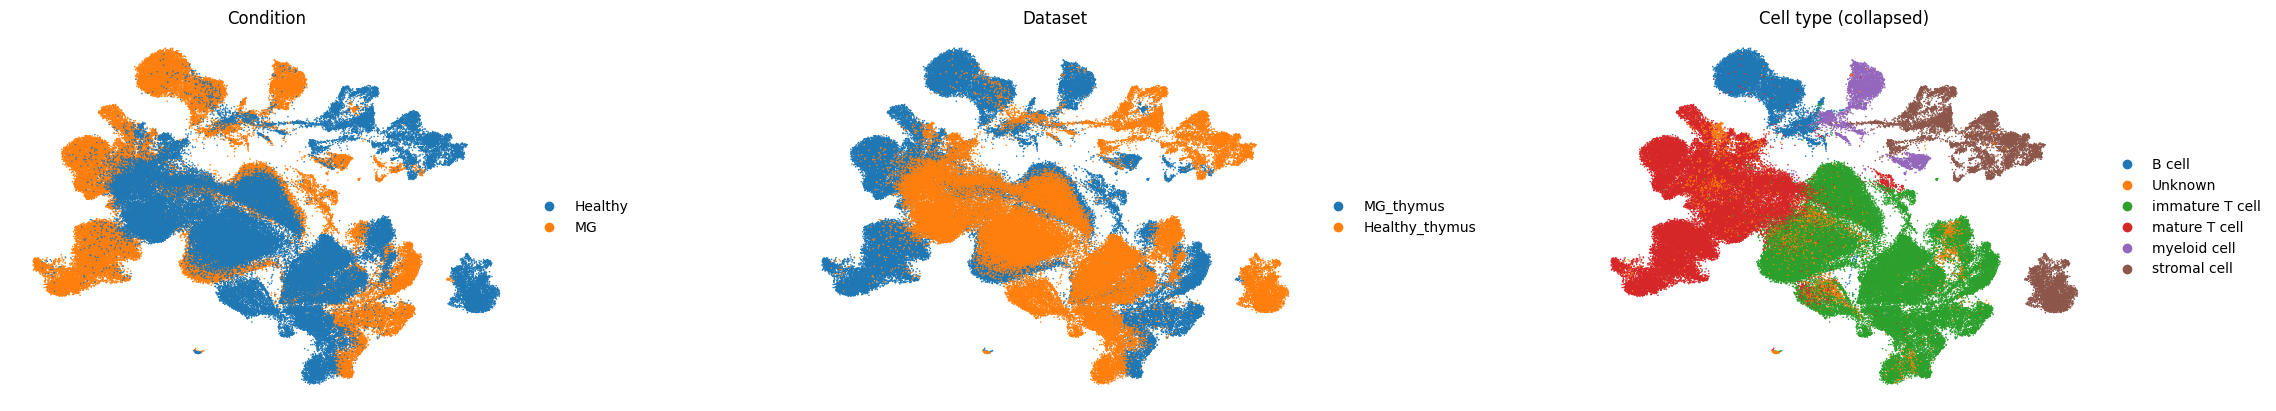

In [115]:
# ------------------------------------------------------------
# UMAP on MOFA latent space
# ------------------------------------------------------------

sc.pp.neighbors(adata_mofa, use_rep="X_mofa")
sc.tl.umap(adata_mofa)

sc.pl.umap(
    adata_mofa,
    color=["condition", "dataset_label", "cell_type_collapsed"],
    frameon=False,
    size=5,
    wspace=0.4,
    title=["Condition", "Dataset", "Cell type (collapsed)"]
)

In [116]:
# ------------------------------------------------------------
# Prepare inputs for metrics
# ------------------------------------------------------------

X = adata_mofa.obsm["X_mofa"]
batch = adata_mofa.obs["condition"].astype(str).values
labels = adata_mofa.obs["cell_type_collapsed"].astype(str).values


# ------------------------------------------------------------
# Build kNN graph (same approach as scVI metrics)
# ------------------------------------------------------------

k = 15

nn_model = NearestNeighbors(
    n_neighbors=k,
    metric="euclidean",
    n_jobs=-1
)
nn_model.fit(X)

distances, indices = nn_model.kneighbors(X)

nn = NeighborsResults(
    indices=indices,
    distances=distances
)


# ------------------------------------------------------------
# Compute MOFA+ metrics
# ------------------------------------------------------------

# iLISI
ilisi_mofa = float(np.mean(scib_metrics.ilisi_knn(nn, batch)))

# kBET (acceptance rate only)
kbet_acc_mofa, _, _ = scib_metrics.kbet(nn, batch)

# Graph connectivity
graph_conn_mofa = scib_metrics.graph_connectivity(nn, labels)

# Silhouette (cell type)
sil_label_mofa = scib_metrics.silhouette_label(
    X=X,
    labels=labels
)

# Silhouette (batch)
sil_batch_mofa = scib_metrics.silhouette_batch(
    X=X,
    labels=labels,
    batch=batch
)

# ARI + NMI (fixed resolution for speed)
ari_nmi_mofa = scib_metrics.nmi_ari_cluster_labels_leiden(
    nn,
    labels,
    optimize_resolution=False,
    resolution=1.0
)


# ------------------------------------------------------------
# Print MOFA+ metrics
# ------------------------------------------------------------

print("\n===== MOFA+ METRICS =====")
print("iLISI:", ilisi_mofa)
print("kBET:", kbet_acc_mofa)
print("Graph connectivity:", graph_conn_mofa)
print("Silhouette (cell type):", sil_label_mofa)
print("Silhouette (batch):", sil_batch_mofa)
print("ARI:", ari_nmi_mofa["ari"])
print("NMI:", ari_nmi_mofa["nmi"])


# ------------------------------------------------------------
# Save MOFA+ metrics
# ------------------------------------------------------------

df_mofa = pd.DataFrame(
    {
        "MOFA+": [
            ilisi_mofa,
            kbet_acc_mofa,
            sil_batch_mofa,
            graph_conn_mofa,
            sil_label_mofa,
            ari_nmi_mofa["ari"],
            ari_nmi_mofa["nmi"],
        ]
    },
    index=[
        "iLISI",
        "kBET",
        "silhouette_batch",
        "graph_connectivity",
        "silhouette_label",
        "ARI",
        "NMI",
    ]
)

df_mofa.to_csv(
    "/content/drive/MyDrive/data_science_final_project/metrics/MOFA_metrics_thymus.csv"
)

df_mofa


===== MOFA+ METRICS =====
iLISI: 1.1920928955078125e-07
kBET: 0.12024397101087092
Graph connectivity: 0.9409849155533951
Silhouette (cell type): 0.53934777
Silhouette (batch): 0.8298125
ARI: 0.16328700982815417
NMI: 0.5021705920584402


,MOFA+
iLISI,1.192093e-07
kBET,1.202440e-01
silhouette_batch,8.298125e-01
graph_connectivity,9.409849e-01
silhouette_label,5.393478e-01
ARI,1.632870e-01
NMI,5.021706e-01


In [117]:
# Ensure same cell order
assert (adata_mofa.obs_names == combined.obs_names).all()


In [121]:
combined.obs["cell_type_collapsed"] = thymus_scvi.obs["cell_type_collapsed"].astype(str)


In [122]:
# Copy harmonized cell-type labels into adata_mofa
adata_mofa.obs["cell_type_collapsed"] = combined.obs["cell_type_collapsed"].astype(str)


In [123]:
print([attr for attr in dir(mofa.model) if "expect" in attr.lower() or "factor" in attr.lower()])


['getExpectations', 'removeInactiveFactors']


In [124]:
import scanpy as sc

# Start from the concatenated dataset
adata_pca = combined.copy()

# Preprocessing
sc.pp.normalize_total(adata_pca, target_sum=1e4)
sc.pp.log1p(adata_pca)

sc.pp.highly_variable_genes(
    adata_pca,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True
)

sc.pp.scale(adata_pca, max_value=10)


In [125]:
assert (adata_pca.obs_names == thymus_scvi.obs_names).all()


In [126]:
adata_pca.obs["cell_type_collapsed"] = thymus_scvi.obs["cell_type_collapsed"].astype(str)


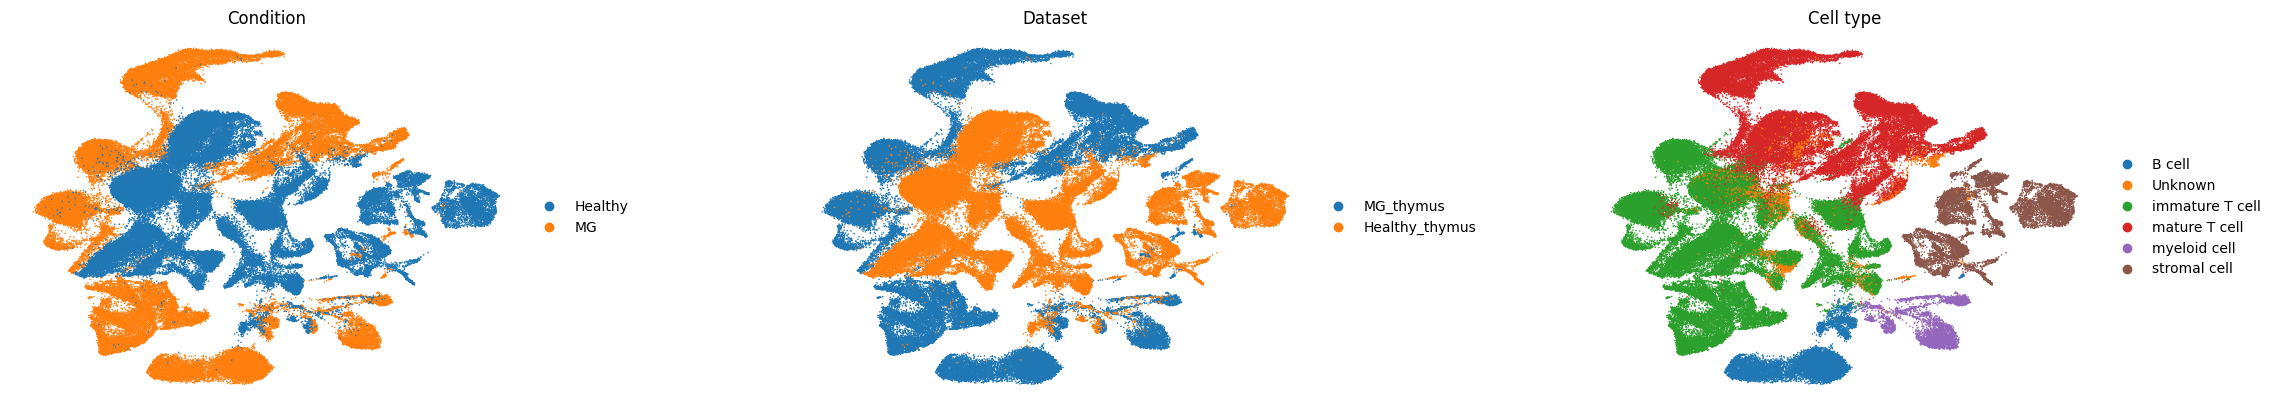

In [127]:
# PCA
sc.tl.pca(adata_pca, n_comps=50)

# Neighbors + UMAP on PCA
sc.pp.neighbors(adata_pca, use_rep="X_pca")
sc.tl.umap(adata_pca)

# Visualization
sc.pl.umap(
    adata_pca,
    color=["condition", "dataset_label", "cell_type_collapsed"],
    frameon=False,
    size=5,
    wspace=0.4,
    title=["Condition", "Dataset", "Cell type"]
)

In [128]:
import numpy as np
import pandas as pd
import scib_metrics
from sklearn.neighbors import NearestNeighbors
from scib_metrics.nearest_neighbors._dataclass import NeighborsResults

# Make sure collapsed labels exist in adata_pca
assert "cell_type_collapsed" in adata_pca.obs.columns

X = adata_pca.obsm["X_pca"]
batch = adata_pca.obs["condition"].astype(str).values
labels = adata_pca.obs["cell_type_collapsed"].astype(str).values

# Build kNN on PCA embedding
k = 15
nn_model = NearestNeighbors(n_neighbors=k, metric="euclidean", n_jobs=-1)
nn_model.fit(X)
distances, indices = nn_model.kneighbors(X)

nn = NeighborsResults(indices=indices, distances=distances)

# Metrics
ilisi_pca = float(np.mean(scib_metrics.ilisi_knn(nn, batch)))
kbet_acc_pca, _, _ = scib_metrics.kbet(nn, batch)
graph_conn_pca = scib_metrics.graph_connectivity(nn, labels)
sil_label_pca = scib_metrics.silhouette_label(X=X, labels=labels)
sil_batch_pca = scib_metrics.silhouette_batch(X=X, labels=labels, batch=batch)
ari_nmi_pca = scib_metrics.nmi_ari_cluster_labels_leiden(
    nn, labels, optimize_resolution=False, resolution=1.0
)

print("\n===== PCA METRICS =====")
print("iLISI:", ilisi_pca)
print("kBET:", kbet_acc_pca)
print("Graph connectivity:", graph_conn_pca)
print("Silhouette (cell type):", sil_label_pca)
print("Silhouette (batch):", sil_batch_pca)
print("ARI:", ari_nmi_pca["ari"])
print("NMI:", ari_nmi_pca["nmi"])

# Save
df_pca = pd.DataFrame(
    {"PCA": [ilisi_pca, kbet_acc_pca, sil_batch_pca, graph_conn_pca, sil_label_pca, ari_nmi_pca["ari"], ari_nmi_pca["nmi"]]},
    index=["iLISI","kBET","silhouette_batch","graph_connectivity","silhouette_label","ARI","NMI"]
)

df_pca.to_csv("/content/drive/MyDrive/data_science_final_project/metrics/PCA_metrics_thymus.csv")
df_pca



===== PCA METRICS =====
iLISI: 0.0
kBET: 0.01728258153192553
Graph connectivity: 0.8949249495230749
Silhouette (cell type): 0.5773856
Silhouette (batch): 0.8065138
ARI: 0.14341893082114457
NMI: 0.49512172961436873


,PCA
iLISI,0.000000
kBET,0.017283
silhouette_batch,0.806514
graph_connectivity,0.894925
silhouette_label,0.577386
ARI,0.143419
NMI,0.495122


In [129]:
!pip install harmonypy


2025-12-14 00:21:13,577 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-12-14 00:21:43,278 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-12-14 00:21:43,893 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-12-14 00:22:44,145 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-12-14 00:23:42,268 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-12-14 00:24:42,716 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-12-14 00:25:40,711 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-12-14 00:26:37,308 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


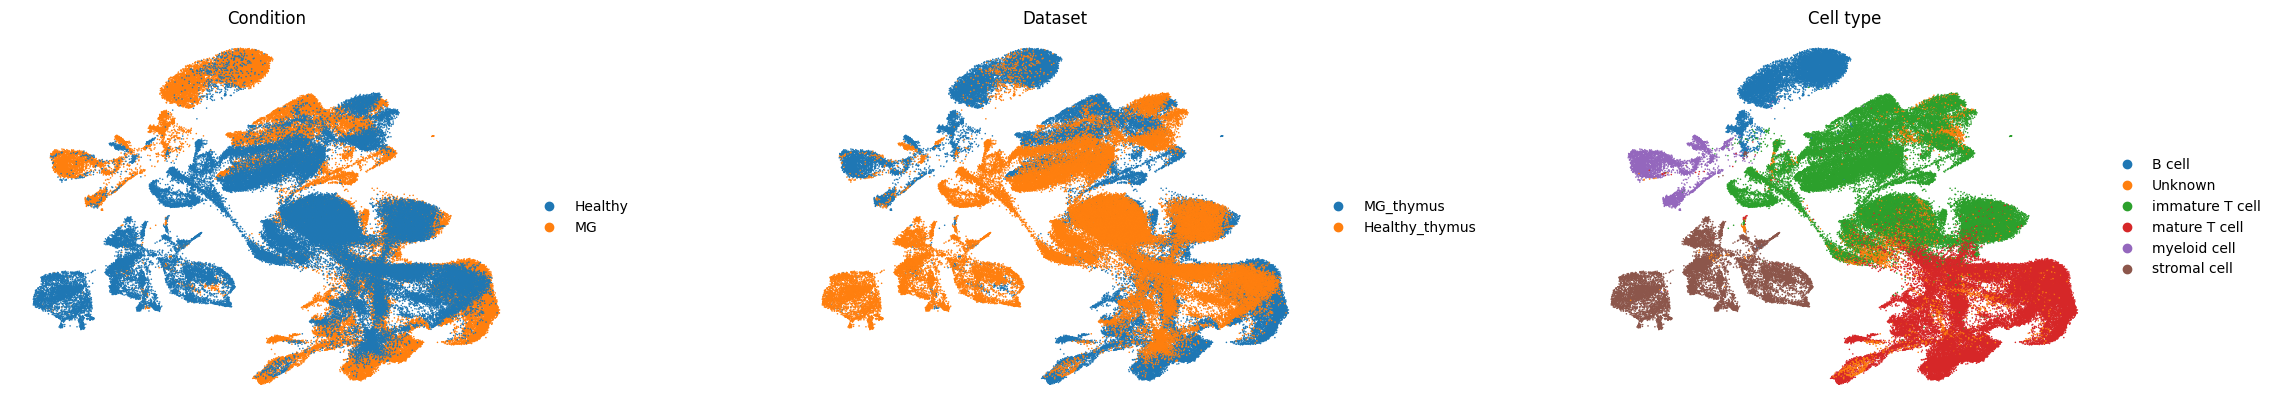

In [130]:
import harmonypy as hm

adata_harmony = adata_pca.copy()  # reuse PCA-preprocessed object

# Run Harmony on PCA embeddings
ho = hm.run_harmony(
    adata_harmony.obsm["X_pca"],
    adata_harmony.obs,
    vars_use=["condition"]   # batch variable
)

# Store corrected embeddings
adata_harmony.obsm["X_harmony"] = ho.Z_corr.T

# Neighbors + UMAP on Harmony space
sc.pp.neighbors(adata_harmony, use_rep="X_harmony")
sc.tl.umap(adata_harmony)

# Visualization
sc.pl.umap(
    adata_harmony,
    color=["condition", "dataset_label", "cell_type_collapsed"],
    frameon=False,
    size=5,
    wspace=0.4,
    title=["Condition", "Dataset", "Cell type"]
)


In [131]:

# HARMONY METRICS


import numpy as np
import pandas as pd
import scib_metrics
from sklearn.neighbors import NearestNeighbors
from scib_metrics.nearest_neighbors._dataclass import NeighborsResults

# ------------------------------------------------------------
# Prepare inputs
# ------------------------------------------------------------

# Ensure harmonized labels exist
assert "cell_type_collapsed" in adata_harmony.obs

X = adata_harmony.obsm["X_harmony"]
batch = adata_harmony.obs["condition"].astype(str).values
labels = adata_harmony.obs["cell_type_collapsed"].astype(str).values


# ------------------------------------------------------------
# Build kNN graph on Harmony embedding
# ------------------------------------------------------------

k = 15

nn_model = NearestNeighbors(
    n_neighbors=k,
    metric="euclidean",
    n_jobs=-1
)
nn_model.fit(X)

distances, indices = nn_model.kneighbors(X)

nn = NeighborsResults(
    indices=indices,
    distances=distances
)


# ------------------------------------------------------------
# Compute Harmony metrics
# ------------------------------------------------------------

# iLISI (batch mixing)
ilisi_harmony = float(np.mean(scib_metrics.ilisi_knn(nn, batch)))

# kBET (acceptance rate)
kbet_acc_harmony, _, _ = scib_metrics.kbet(nn, batch)

# Graph connectivity (cell-type preservation)
graph_conn_harmony = scib_metrics.graph_connectivity(nn, labels)

# Silhouette (cell type)
sil_label_harmony = scib_metrics.silhouette_label(
    X=X,
    labels=labels
)

# Silhouette (batch)
sil_batch_harmony = scib_metrics.silhouette_batch(
    X=X,
    labels=labels,
    batch=batch
)

# ARI + NMI (Leiden clustering agreement)
ari_nmi_harmony = scib_metrics.nmi_ari_cluster_labels_leiden(
    nn,
    labels,
    optimize_resolution=False,
    resolution=1.0
)


# ------------------------------------------------------------
# Print Harmony metrics
# ------------------------------------------------------------

print("\n===== HARMONY METRICS =====")
print("iLISI:", ilisi_harmony)
print("kBET:", kbet_acc_harmony)
print("Graph connectivity:", graph_conn_harmony)
print("Silhouette (cell type):", sil_label_harmony)
print("Silhouette (batch):", sil_batch_harmony)
print("ARI:", ari_nmi_harmony["ari"])
print("NMI:", ari_nmi_harmony["nmi"])


# ------------------------------------------------------------
# Save Harmony metrics
# ------------------------------------------------------------

df_harmony = pd.DataFrame(
    {
        "Harmony": [
            ilisi_harmony,
            kbet_acc_harmony,
            sil_batch_harmony,
            graph_conn_harmony,
            sil_label_harmony,
            ari_nmi_harmony["ari"],
            ari_nmi_harmony["nmi"],
        ]
    },
    index=[
        "iLISI",
        "kBET",
        "silhouette_batch",
        "graph_connectivity",
        "silhouette_label",
        "ARI",
        "NMI",
    ]
)

df_harmony.to_csv(
    "/content/drive/MyDrive/data_science_final_project/metrics/Harmony_metrics_thymus.csv"
)

df_harmony



===== HARMONY METRICS =====
iLISI: 2.384185791015625e-07
kBET: 0.18829657628389354
Graph connectivity: 0.8650264784926746
Silhouette (cell type): 0.58482814
Silhouette (batch): 0.8653156
ARI: 0.18836167438453771
NMI: 0.5144083372698839


,Harmony
iLISI,2.384186e-07
kBET,1.882966e-01
silhouette_batch,8.653156e-01
graph_connectivity,8.650265e-01
silhouette_label,5.848281e-01
ARI,1.883617e-01
NMI,5.144083e-01
